# Projet 3: Classification d’images avec CIFAR-10 (CNN)

# Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

EPOCHS = 64
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print("TensorFlow version:", tf.__version__)

2026-01-13 20:01:31.803624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768334492.012387      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768334492.073321      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768334492.582321      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768334492.582365      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768334492.582367      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0


# Chargement du dataset CIFAR-10

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


# Data Exploration (EDA)

## Distribution des classes

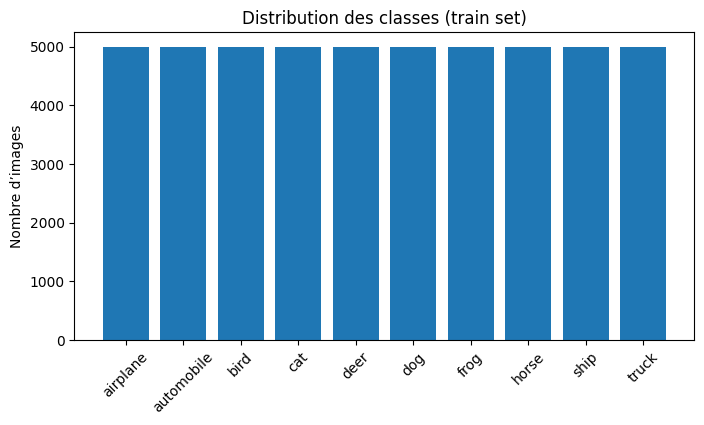

In [3]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(8,4))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Distribution des classes (train set)")
plt.ylabel("Nombre d’images")
plt.show()

## Exemples d’images

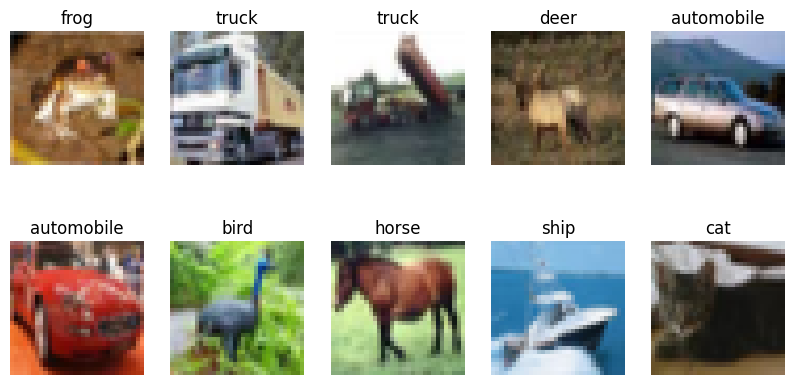

In [4]:
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")

plt.show()

# Prétraitement des données

In [5]:
# CIFAR-10 est un dataset propre
print("NaN train:", np.isnan(X_train).any())
print("NaN test :", np.isnan(X_test).any())

NaN train: False
NaN test : False


## Normalisation

In [6]:
print("Plage de pixels (avant normalisation):", X_train.min(), X_train.max())

X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

print("Plage de pixels (après normalisation):", X_train.min(), X_train.max())

Plage de pixels (avant normalisation): 0 255
Plage de pixels (après normalisation): 0.0 1.0


## One-hot encoding

In [7]:
y_train_cat = to_categorical(y_train, len(class_names))
y_test_cat = to_categorical(y_test, len(class_names))

## Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

I0000 00:00:1768334515.007228      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


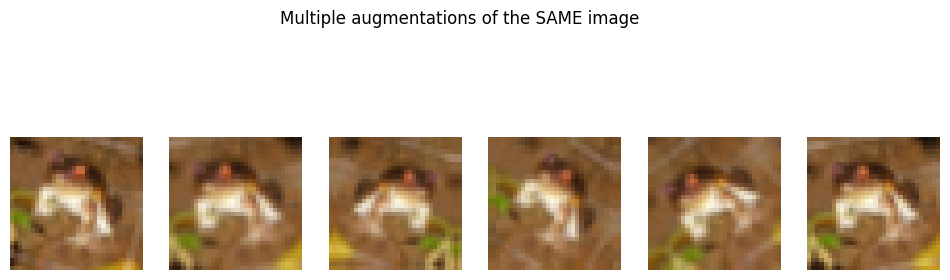

In [9]:
plt.figure(figsize=(12,4))

image = X_train[0]

for i in range(6):
    augmented = data_augmentation(image[None, ...])
    plt.subplot(1,6,i+1)
    plt.imshow(augmented[0])
    plt.axis("off")

plt.suptitle("Multiple augmentations of the SAME image")
plt.show()

# Modèle CNN

In [10]:
CNN_LR = 1e-4

## Création de modèle

In [11]:
cnn_model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

In [12]:
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=CNN_LR)

cnn_model.compile(
    optimizer=cnn_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 32, 32, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 32, 32, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 16, 16, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 16, 16, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 16, 16, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (1, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 8, 8, 128)         │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (1, 4, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 4, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 10)                │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement

In [14]:
history_cnn = cnn_model.fit(
    X_train, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)

Epoch 1/64


E0000 00:00:1768334521.436688      24 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1768334522.176792      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2004 - loss: 2.1326 - val_accuracy: 0.3751 - val_loss: 1.7538
Epoch 2/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3599 - loss: 1.7642 - val_accuracy: 0.4317 - val_loss: 1.5763
Epoch 3/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4061 - loss: 1.6377 - val_accuracy: 0.4551 - val_loss: 1.5017
Epoch 4/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4287 - loss: 1.5723 - val_accuracy: 0.4668 - val_loss: 1.4624
Epoch 5/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4509 - loss: 1.5181 - val_accuracy: 0.4796 - val_loss: 1.4438
Epoch 6/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4642 - loss: 1.4757 - val_accuracy: 0.5120 - val_loss: 1.3701
Epoch 7/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4861 - loss: 1.4348 - val_accuracy: 0.4949 - val_loss: 1.4125
Epoch 8/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4966 - loss: 1.4026 - val_acc

## Overfitting & régularisation – courbes

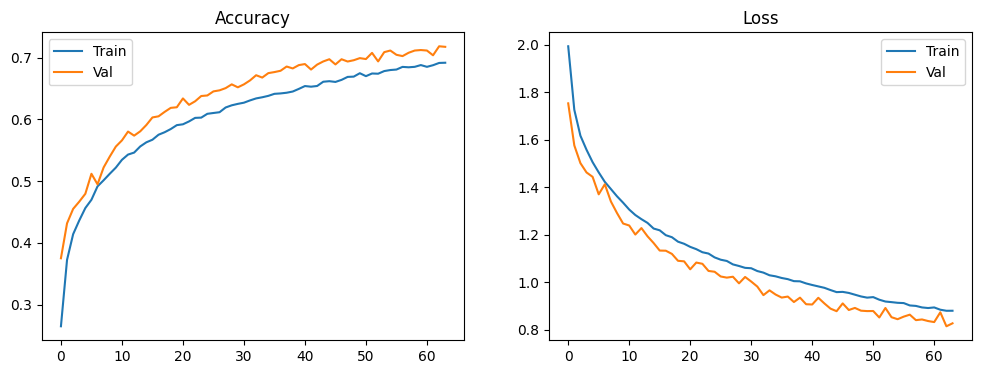

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_cnn.history["accuracy"], label="Train")
plt.plot(history_cnn.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history["loss"], label="Train")
plt.plot(history_cnn.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()

## Évaluation

In [16]:
cnn_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)[1]
print("CNN Test Accuracy:", cnn_acc)

CNN Test Accuracy: 0.7106999754905701


In [17]:
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)

print(classification_report(
    y_test.flatten(),
    y_pred,
    target_names=class_names
))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.71      0.81      0.75      1000
  automobile       0.76      0.90      0.82      1000
        bird       0.80      0.44      0.57      1000
         cat       0.65      0.41      0.50      1000
        deer       0.69      0.62      0.65      1000
         dog       0.71      0.58      0.64      1000
        frog       0.61      0.90      0.72      1000
       horse       0.68      0.85      0.75      1000
        ship       0.88      0.79      0.83      1000
       truck       0.71      0.82      0.76      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.70     10000
weighted avg       0.72      0.71      0.70     10000



## Matrice de confusion

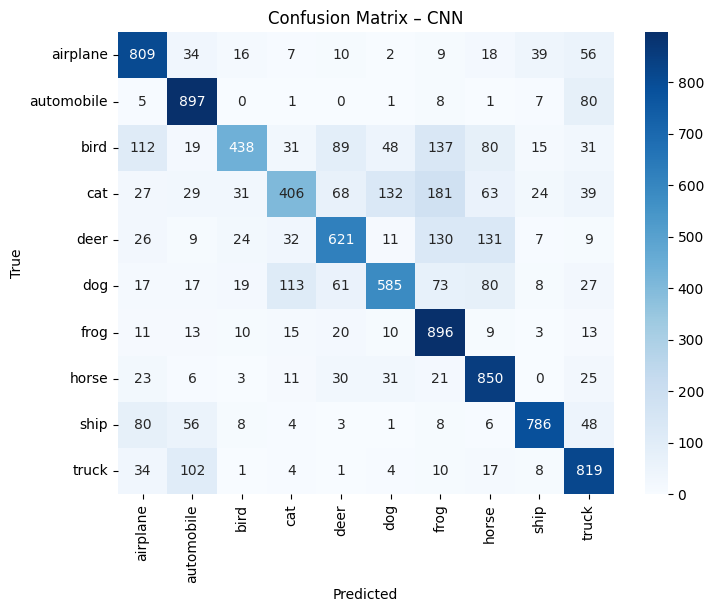

In [18]:
cm = confusion_matrix(y_test.flatten(), y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CNN")
plt.show()

## Sauvegarde du modèle

In [19]:
cnn_model.save("cnn_cifar10_model.keras")

# Modèle MLP (sans convolution)

In [20]:
MLP_LR = 1e-4

## Création de modèle

In [21]:
mlp_model = models.Sequential([
    layers.Flatten(input_shape=(32,32,3)),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
mlp_optimizer = tf.keras.optimizers.Adam(learning_rate=MLP_LR)

mlp_model.compile(
    optimizer=mlp_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Entraînement

In [23]:
history_mlp = mlp_model.fit(
    X_train, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)

Epoch 1/64


I0000 00:00:1768335174.377223      70 service.cc:152] XLA service 0x2fe57f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768335174.377261      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  56/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1155 - loss: 2.4229

I0000 00:00:1768335176.350283      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2248 - loss: 2.1135 - val_accuracy: 0.3520 - val_loss: 1.8356
Epoch 2/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3345 - loss: 1.8478 - val_accuracy: 0.3872 - val_loss: 1.7477
Epoch 3/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3595 - loss: 1.7806 - val_accuracy: 0.4063 - val_loss: 1.6951
Epoch 4/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3854 - loss: 1.7237 - val_accuracy: 0.4130 - val_loss: 1.6581
Epoch 5/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3974 - loss: 1.6846 - val_accuracy: 0.4261 - val_loss: 1.6302
Epoch 6/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4107 - loss: 1.6553 - val_accuracy: 0.4373 - val_loss: 1.5915
Epoch 7/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4210 - loss: 1.6252 - val_accuracy: 0.4450 - val_loss: 1.5752
Epoch 8/64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4314 - loss: 1.5921 - val_accurac

## Overfitting & régularisation – courbes

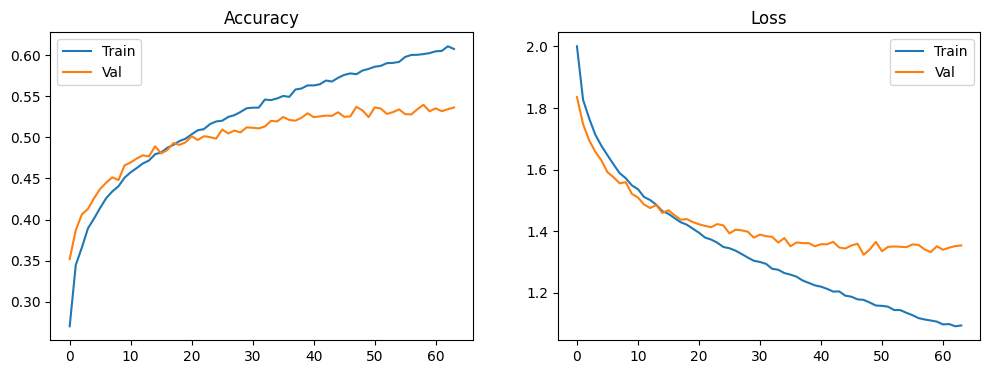

In [24]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_mlp.history["accuracy"], label="Train")
plt.plot(history_mlp.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mlp.history["loss"], label="Train")
plt.plot(history_mlp.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()

## Sauvegarde du modèle

In [25]:
mlp_model.save("mlp_cifar10_model.keras")

# Comparaison CNN vs MLP

In [26]:
mlp_acc = mlp_model.evaluate(X_test, y_test_cat, verbose=0)[1]

print("CNN Accuracy:", cnn_acc)
print("MLP Accuracy:", mlp_acc)

CNN Accuracy: 0.7106999754905701
MLP Accuracy: 0.5370000004768372


# Hyperparameter Tuning

In [27]:
configs = [
    {"filters": 32, "dropout": 0.3},
    {"filters": 64, "dropout": 0.4},
    {"filters": 64, "dropout": 0.5},
]

In [28]:
results = []

for cfg in configs:
    model = models.Sequential([
        layers.Conv2D(cfg["filters"], (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(cfg["dropout"]),
        layers.Flatten(),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    h = model.fit(
        X_train, y_train_cat,
        epochs=5,
        batch_size=128,
        validation_split=0.2,
        verbose=0
    )

    results.append((cfg, max(h.history["val_accuracy"])))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
results

[({'filters': 32, 'dropout': 0.3}, 0.6064000129699707),
 ({'filters': 64, 'dropout': 0.4}, 0.6050999760627747),
 ({'filters': 64, 'dropout': 0.5}, 0.6114000082015991)]

# Explicabilité

## Visualisation des filtres convolutifs

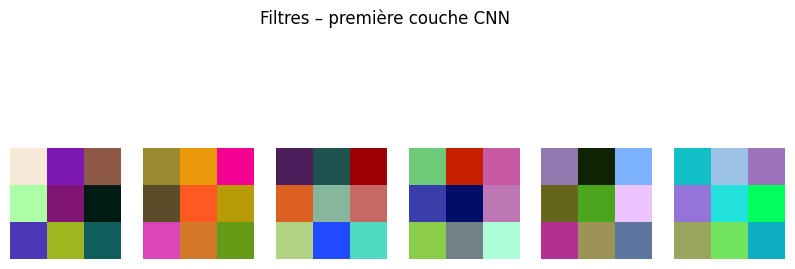

In [30]:
filters, biases = cnn_model.layers[1].get_weights()

plt.figure(figsize=(10,4))

for i in range(6):
    f = filters[:,:,:,i]
    f = (f - f.min()) / (f.max() - f.min())
    plt.subplot(1,6,i+1)
    plt.imshow(f)
    plt.axis("off")
    
plt.suptitle("Filtres – première couche CNN")
plt.show()

## Feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


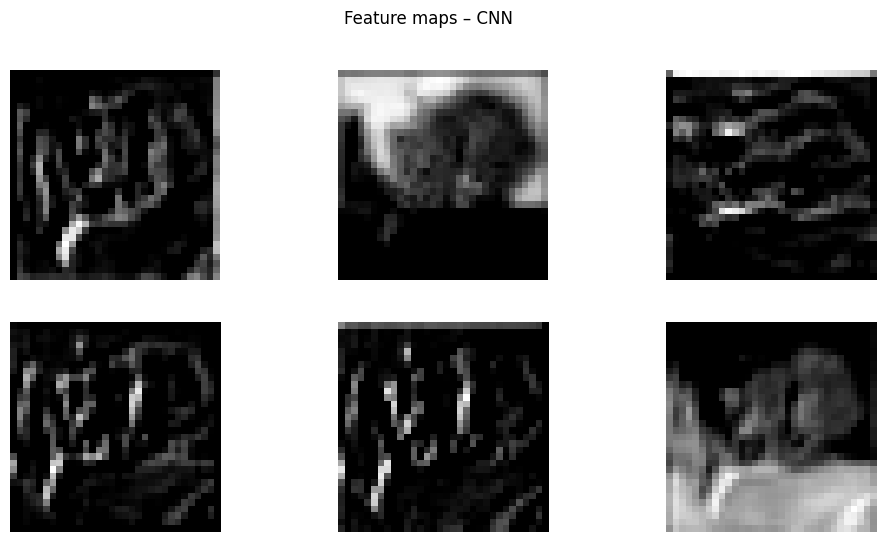

In [31]:
from tensorflow.keras.models import Model

img = X_test[0:1]

feature_model = Model(
    inputs=cnn_model.inputs,
    outputs=cnn_model.layers[1].output
)

feature_maps = feature_model.predict(img)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap="gray")
    plt.axis("off")
    
plt.suptitle("Feature maps – CNN")
plt.show()

## Saliency Map

I0000 00:00:1768335491.666140      24 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x2f615c00


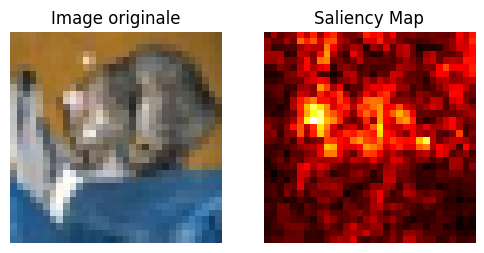

In [32]:
img_tensor = tf.convert_to_tensor(img)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    preds = cnn_model(img_tensor)
    loss = preds[:, tf.argmax(preds[0])]

grads = tape.gradient(loss, img_tensor)
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.title("Image originale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(saliency, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()

# Model loading

In [33]:
# from tensorflow.keras.models import load_model

# cnn_loaded = load_model("cnn_cifar10_model")
# mlp_loaded = load_model("mlp_cifar10_model")